In [84]:
import pandas as pd

seed = 42

## Dataset loading (read generated pkl files)

In [99]:
BP_train = pd.read_pickle("dataset/BP_train_solution_mod.pkl")
BP_test = pd.read_pickle("dataset/BP_test_solution_mod.pkl")
SC_train = pd.read_pickle("dataset/SC_train_solution_mod.pkl")
SC_test = pd.read_pickle("dataset/SC_test_solution_mod.pkl")

BP_train = BP_train.sample(frac=1, random_state=seed)
BP_test = BP_test.sample(frac=1, random_state=seed)
SC_train = SC_train.sample(frac=1, random_state=seed)
SC_test = SC_test.sample(frac=1, random_state=seed)

train = pd.concat([BP_train, SC_train], ignore_index=True)
test = pd.concat([BP_test, SC_test], ignore_index=True)

X_train = train.drop(columns=['score'])
Y_train = train['score']

X_test = test.drop(columns=['score'])
Y_test = test['score']

X = pd.concat([X_train, X_test], ignore_index=True)
Y = pd.concat([Y_train, Y_test], ignore_index=True)

In [100]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

kb = SelectKBest(f_regression, k=10).fit(X, Y)
X_train = kb.transform(X_train)
features = kb.get_feature_names_out()
X_test = kb.transform(X_test)

## Preprocessing

In [101]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

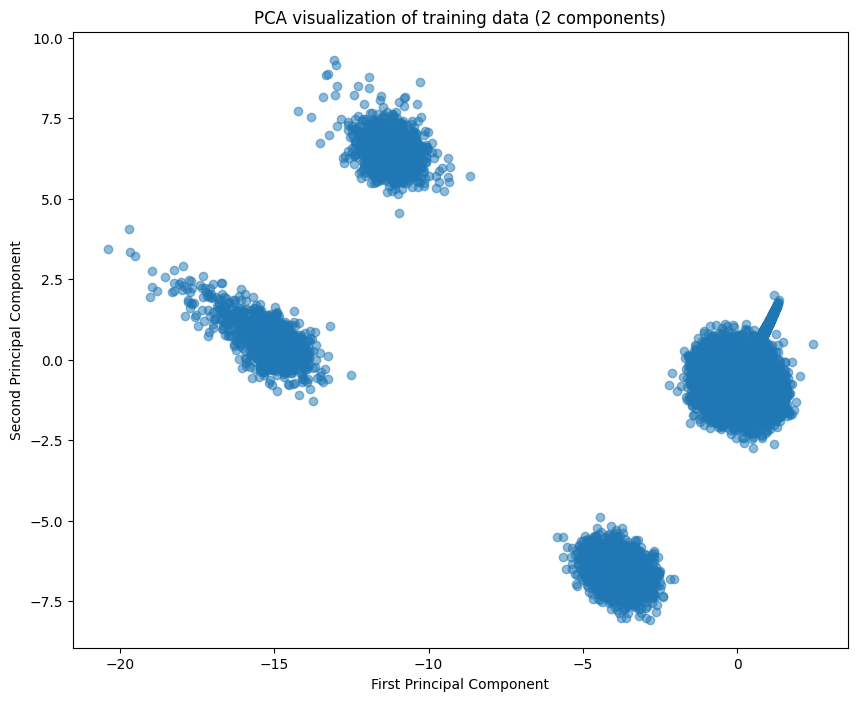

In [88]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# First PCA visualization
pca1 = PCA(n_components=2)
X_train_pca1 = pca1.fit_transform(X_train)

plt.figure(figsize=(10, 8))
plt.title('PCA visualization of training data (2 components)')
plt.scatter(X_train_pca1[:,0], X_train_pca1[:,1], alpha=0.5)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

## Extra Tree Regressor

In [102]:
from sklearn.model_selection import KFold
from sklearn.ensemble import ExtraTreesRegressor

kf = KFold(n_splits=5, shuffle=True, random_state=seed)

params = {
    # "n_estimators": [10, 20, 50, 100],
    # "min_samples_leaf": [5, 10, 20, 30],
    # "max_depth": [5, 10, 20],
    "n_estimators": [10],
    "min_samples_leaf": [5],
    "max_depth": [5],
}


scoring = (
    'r2',
    'neg_mean_squared_error',
    'neg_mean_absolute_error',
)
for train, test in kf.split(X, Y):
    X_train, X_test = X.iloc[train], X.iloc[test]
    Y_train, Y_test = Y.iloc[train], Y.iloc[test]

    et = ExtraTreesRegressor(random_state=seed, n_jobs=4)
    gs = GridSearchCV(et, param_grid=params, cv=5, scoring='r2', n_jobs=4, return_train_score=True)
    gs.fit(X_train, Y_train)

    print("Best score: ", gs.best_score_)
    print("Best params: ", gs.best_params_)

    scores = gs.score(X_test, Y_test)
    print(f"Score: {scores:.4f}")

Best score:  0.852783043063783
Best params:  {'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 10}
Score: 0.9956
Best score:  0.861160270950481
Best params:  {'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 10}
Score: 0.9951
Best score:  0.8476116923991615
Best params:  {'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 10}
Score: 0.9949
Best score:  0.8698480350164406
Best params:  {'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 10}
Score: 0.9956
Best score:  0.8568255252204153
Best params:  {'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 10}
Score: 0.9960


In [103]:
from imodels import HSTreeRegressorCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error, max_error

mdl = HSTreeRegressorCV(et, max_leaf_nodes=5)
mdl.fit(X_train, Y_train, feature_names=features)
preds = mdl.predict(X_test)
print("MSE: ", mean_squared_error(Y_test, preds))
print("MAPE: ", mean_absolute_percentage_error(Y_test, preds))
print("Max error: ", max_error(Y_test, preds))
print("R2: ", r2_score(Y_test, preds))
# print(mdl)

InvalidIndexError: (array([    0,     1,     2, ..., 27648, 27649, 27650]), slice(None, None, None))

In [104]:
from imodels import BoostedRulesRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error, max_error

mdl = BoostedRulesRegressor(et, n_estimators=10, random_state=seed)
mdl.fit(X_train, Y_train, feature_names=features)
preds = mdl.predict(X_test)
preds_proba = mdl.predict(X_test)
print("MSE: ", mean_squared_error(Y_test, preds))
print("MAPE: ", mean_absolute_percentage_error(Y_test, preds))
print("Max error: ", max_error(Y_test, preds))
print("R2: ", r2_score(Y_test, preds))

AssertionError: feature_names should be same size as X.shape[1]